# Construction Damage ChatBot

In [ ]:
# 📦 Install required libraries (run once in Google Colab)

!pip install sympy==1.12 Pillow requests gradio --upgrade
!pip install torch==2.2.2 torchvision==0.17.2 torchaudio --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
!pip install numpy==1.26.4

In [ ]:
from google.colab import userdata
import os
os.environ["GROQ_API_KEY"] = userdata.get('ChatBot_using_GroqAPI')


In [4]:
# 🧠 Construction Damage Chatbot – Gradio App with Debugging for Colab

# ✅ Import Modules
import os
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import gradio as gr
import requests
import json
import numpy as np

# ✅ Load MobileNetV2 Model
print("📦 Loading MobileNetV2 model...")
model = models.mobilenet_v2(pretrained=True)
model.eval()
print("✅ Model loaded.")

# ✅ Load ImageNet Labels
print("📥 Downloading ImageNet class labels...")
LABELS_URL = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
imagenet_classes = requests.get(LABELS_URL).text.strip().split("\n")

# ✅ Define Image Transform
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# ✅ Step 1: Classify Image
def classify_image(img):
    print("🖼️ Classifying image...")
    print(f"📏 Image shape: {img.shape}")
    image = Image.fromarray(img).convert("RGB")
    input_tensor = preprocess(image).unsqueeze(0)
    with torch.no_grad():
        output = model(input_tensor)
    predicted_idx = output.argmax(1).item()
    label = imagenet_classes[predicted_idx]
    print(f"✅ Detected: {label}")
    return label

# ✅ Step 2: Query Groq LLM
def query_groq(prompt):
    print("🤖 Sending request to Groq...")
    api_key = os.environ.get("GROQ_API_KEY")
    if not api_key:
        return "🚨 ERROR: GROQ_API_KEY is missing. Make sure it's set using userdata."

    url = "https://api.groq.com/openai/v1/chat/completions"
    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json"
    }
    body = {
        "model": "llama3-70b-8192",
        "messages": [
            {
                "role": "system",
                "content": (
                    "You are a Civil Engineering Assistant specialized in construction damage. "
                    "When given a description like 'cracked wall' or 'rusted pipe', provide:\n"
                    "- Type of damage\n- Cause of damage\n- Suggested repair technique\n"
                    "- Tools required\n- Estimated repair time\n- Safety precautions."
                )
            },
            {
                "role": "user",
                "content": prompt
            }
        ],
        "temperature": 0.7
    }

    try:
        response = requests.post(url, headers=headers, json=body, timeout=30)
        if response.status_code == 200:
            print("✅ Received response from Groq.")
            return response.json()["choices"][0]["message"]["content"]
        else:
            print(f"❌ Groq API Error: {response.status_code} - {response.text}")
            return f"❌ Groq API Error: {response.status_code} - {response.text}"
    except Exception as e:
        print(f"❌ Exception while calling Groq API: {str(e)}")
        return f"❌ Exception: {str(e)}"

# ✅ Step 3: Gradio Logic
def analyze_image(image):
    print("🚀 Image received. Starting analysis...")
    if image is None:
        print("❌ No image received!")
        return "❌ Please upload a valid image."

    label = classify_image(image)
    prompt = f"The uploaded image shows: {label}. Please analyze it."
    ai_response = query_groq(prompt)
    print("🎯 Returning AI Response.")
    return f"🔍 Detected Damage: {label}\n\n🧠 AI Repair Suggestion:\n{ai_response}"

# ✅ Gradio Interface
iface = gr.Interface(
    fn=analyze_image,
    inputs=gr.Image(type="numpy", label="Upload Damage Image"),
    outputs=gr.Markdown(label="AI Assistant Response"),
    title="🏗️ Construction Damage Chatbot",
    description="Upload an image of construction damage (e.g., cracked wall, rusted pipe). AI will detect and suggest repair."
)

iface.queue()
iface.launch(share=True, debug=True)  # ✅ Essential for Colab interaction

📦 Loading MobileNetV2 model...
✅ Model loaded.
📥 Downloading ImageNet class labels...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://1eebc1606a4baaf1ac.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


🚀 Image received. Starting analysis...
🖼️ Classifying image...
📏 Image shape: (379, 581, 3)
✅ Detected: cliff dwelling
🤖 Sending request to Groq...
✅ Received response from Groq.
🎯 Returning AI Response.
🚀 Image received. Starting analysis...
🖼️ Classifying image...
📏 Image shape: (399, 526, 3)
✅ Detected: boathouse
🤖 Sending request to Groq...
✅ Received response from Groq.
🎯 Returning AI Response.
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://1eebc1606a4baaf1ac.gradio.live


# 📄 Fully Expanded Advanced Version (with detailed print returns--non Gradio):


📦 Loading MobileNetV2 model...
✅ Model loaded.
📥 Downloading ImageNet class labels...
📤 Please upload a construction damage image (e.g., crack, rust, etc.)


Saving Screenshot 2025-07-12 221348.png to Screenshot 2025-07-12 221348.png
📷 Uploaded Image: Screenshot 2025-07-12 221348.png, size: (628, 353)


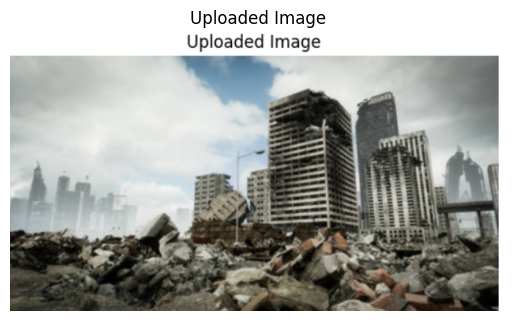


🔍 STEP 1: Running classify_image(img)...
📏 Image shape: (628, 353)
✅ classify_image() return: seashore

🤖 STEP 2: Running query_groq(prompt)...
📝 Prompt being sent to Groq:

    An image classification model predicted the image label as: 'seashore', but this may be incorrect due to visual ambiguity. The image could potentially depict construction-related damage such as:

    - Collapsed buildings
    - Structural cracks
    - Rubble or debris
    - Damaged walls, floors, or infrastructure
    - Rusted or corroded materials
    - Natural disaster aftermath (e.g. earthquake, flood)

    Please analyze the image from a civil engineering perspective. If there is any indication of damage, provide a detailed report that includes:

    1. 📌 Type of damage (if present)  
    2. 🛠️ Likely cause  
    3. 🧰 Suggested repair technique  
    4. 🔧 Tools and equipment needed  
    5. ⏳ Estimated repair time  
    6. ⚠️ Safety precautions

    If the image does not show any obvious construction damag

In [13]:
# 🧠 Construction Damage Chatbot – Colab Version (with Trace Prints)

# ✅ Import Modules
import os
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from io import BytesIO

# ✅ Load MobileNetV2 Model
print("📦 Loading MobileNetV2 model...")
model = models.mobilenet_v2(pretrained=True)
model.eval()
print("✅ Model loaded.")

# ✅ Load ImageNet Labels
print("📥 Downloading ImageNet class labels...")
LABELS_URL = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
imagenet_classes = requests.get(LABELS_URL).text.strip().split("\n")

# ✅ Define Image Transform
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# ✅ Step 1: Classify Image
def classify_image(img):
    print("\n🔍 STEP 1: Running classify_image(img)...")
    print(f"📏 Image shape: {img.size}")
    input_tensor = preprocess(img).unsqueeze(0)
    with torch.no_grad():
        output = model(input_tensor)
    predicted_idx = output.argmax(1).item()
    label = imagenet_classes[predicted_idx]
    print(f"✅ classify_image() return: {label}")
    return label

# ✅ Step 2: Query Groq LLM
def query_groq(prompt):
    print("\n🤖 STEP 2: Running query_groq(prompt)...")
    print(f"📝 Prompt being sent to Groq:\n{prompt}\n")
    api_key = os.environ.get("GROQ_API_KEY")
    if not api_key:
        error_msg = "🚨 ERROR: GROQ_API_KEY is missing. Please set it with os.environ['GROQ_API_KEY'] = 'your_key_here'"
        print(error_msg)
        return error_msg

    url = "https://api.groq.com/openai/v1/chat/completions"
    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json"
    }
    body = {
        "model": "llama3-70b-8192",
        "messages": [
            {
                "role": "system",
                "content": (
                    "You are a Civil Engineering Assistant specialized in construction damage. "
                    "When given a description like 'cracked wall' or 'rusted pipe', provide:\n"
                    "- Type of damage\n- Cause of damage\n- Suggested repair technique\n"
                    "- Tools required\n- Estimated repair time\n- Safety precautions."
                )
            },
            {
                "role": "user",
                "content": prompt
            }
        ],
        "temperature": 0.7
    }

    try:
        response = requests.post(url, headers=headers, json=body, timeout=30)
        if response.status_code == 200:
            ai_reply = response.json()["choices"][0]["message"]["content"]
            print("✅ query_groq() return:\n", ai_reply)
            return ai_reply
        else:
            error_msg = f"❌ Groq API Error: {response.status_code} - {response.text}"
            print(error_msg)
            return error_msg
    except Exception as e:
        error_msg = f"❌ Exception while calling Groq API: {str(e)}"
        print(error_msg)
        return error_msg

# ✅ Main Pipeline in Colab
def run_pipeline():
    print("📤 Please upload a construction damage image (e.g., crack, rust, etc.)")
    uploaded = files.upload()

    if not uploaded:
        print("❌ No file uploaded.")
        return

    image_path = next(iter(uploaded))
    img = Image.open(image_path).convert("RGB")
    print(f"📷 Uploaded Image: {image_path}, size: {img.size}")

    # Display image
    plt.imshow(img)
    plt.axis('off')
    plt.title("Uploaded Image")
    plt.show()

    # 🔍 Step 1
    label = classify_image(img)

    # 🤖 Step 2
    prompt = f"""
    An image classification model predicted the image label as: '{label}', but this may be incorrect due to visual ambiguity. The image could potentially depict construction-related damage such as:

    - Collapsed buildings
    - Structural cracks
    - Rubble or debris
    - Damaged walls, floors, or infrastructure
    - Rusted or corroded materials
    - Natural disaster aftermath (e.g. earthquake, flood)

    Please analyze the image from a civil engineering perspective. If there is any indication of damage, provide a detailed report that includes:

    1. 📌 Type of damage (if present)
    2. 🛠️ Likely cause
    3. 🧰 Suggested repair technique
    4. 🔧 Tools and equipment needed
    5. ⏳ Estimated repair time
    6. ⚠️ Safety precautions

    If the image does not show any obvious construction damage, explain your reasoning clearly.
    """


    ai_response = query_groq(prompt)

    # 🎯 Final Output
    print("\n🎯 FINAL ANALYSIS")
    print(f"🔍 Detected Damage: {label}")
    print("🧠 AI Repair Suggestion:\n", ai_response)

# ✅ Run it!
run_pipeline()
